In [1]:
%load_ext autoreload

%autoreload 2
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split as tts
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy as dp
import time 
from IPython.display import clear_output
import matplotlib.pyplot as plt
import dataloader as dt
import allmodel as am
from scipy import signal as S
from torcheval.metrics.functional import multiclass_f1_score as f1
import utils
import train

In [2]:
import torch
import torch.nn as nn
import time

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
def timeM(model,Input):
    t = time.time()
    out = model(Input)
    print(time.time()-t)
    return

In [4]:
import allmodel as am

model =am.LSTM(8, 400, 2, 0.2)
modelCNN = am.CNN2h(200,8,(1,8,200))
modelYOLO = am.yolo(200,8,(1,8,200))
print(count_parameters(model),count_parameters(modelCNN),count_parameters(modelYOLO),
    timeM(model,torch.rand((1,200,8))),timeM(modelCNN,torch.rand(1,8,200)),timeM(modelYOLO,torch.rand(1,8,200)))

torch.Size([1, 3136])
0.33263635635375977
0.0009922981262207031
0.005002021789550781
2099600 876704 3275887 None None None


In [5]:
ws=80
d = dt.Dataloader(ws,1)
d.split(['Person (1)','Person (2)','Person (3)'])
d.load()
d.binary_labels()


In [ ]:
Data,DataC,label,relaxlabel,labelC,relaxlabelC,_,TestData,TestDataC,testlabel,testlabelC,testrelaxlabel,testrelaxlabelC,_ = d.fetch(10,ws,Gyro=False)

Filtering Signal
Adding magnitude as feature


In [ ]:
DataC = DataC.permute(0,2,1)
labelC = labelC.permute(0,2,1)
relaxlabelC = relaxlabelC.permute(0,2,1)
TestDataC = TestDataC.permute(0,2,1)
testlabelC = testlabelC.permute(0,2,1)
testrelaxlabelC = testrelaxlabelC.permute(0,2,1)

In [43]:
DataC.shape

torch.Size([2890328, 80, 4])

In [5]:

ws1,we1,ws0,we0 = utils.count_imbalance(label,'cuda')
ws1r,we1r,ws0r,we0r = utils.count_imbalance(relaxlabel,'cuda')

print('True labels:\n',ws1.item(),we1.item(),ws0.item(),we0.item(),'\nRelaxed labels:\n',ws1r.item(),we1r.item(),ws0r.item(),we0r.item())

True labels:
 28.102909088134766 28.102909088134766 0.5090569853782654 0.5090569853782654 
Relaxed labels:
 1.4051510095596313 1.4051510095596313 0.7761970162391663 0.7761970162391663


In [8]:
channel = 4
batch_size=1024
# Create an instance of the LSTM network
model = am.LSTM(channel, 400, 2, 0.2).cuda()
modelrelax = am.LSTM(channel, 400, 2, 0.2).cuda()


In [9]:


# Create a DataLoader for batching
#dataset = torch.utils.data.TensorDataset(DataC[722582*0:722582*1].float().cuda(), labelC[722582*0:722582*1].float().cuda())
#dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

datasetrelax = torch.utils.data.TensorDataset(DataC[722582*2:722582*3].float().cuda(), relaxlabelC[722582*2:722582*3].float().cuda())
dataloaderrelax = torch.utils.data.DataLoader(datasetrelax, batch_size=batch_size, shuffle=True)

In [ ]:
#model,his = train.train_lstm(model,dataloader,ws0,we0,ws1,we1,lr=0.0001,epochs=5)

In [16]:
modelrelax,hisrelax =  train.train_lstm(modelrelax,dataloaderrelax,ws0r,we0r,ws1r,we1r,ws,epochs=5,lr=0.0001)

Epoch 1/5 - Loss: 0.276196
Epoch 2/5 - Loss: 0.247570
Epoch 3/5 - Loss: 0.228397
Epoch 4/5 - Loss: 0.214364
Epoch 5/5 - Loss: 0.202025


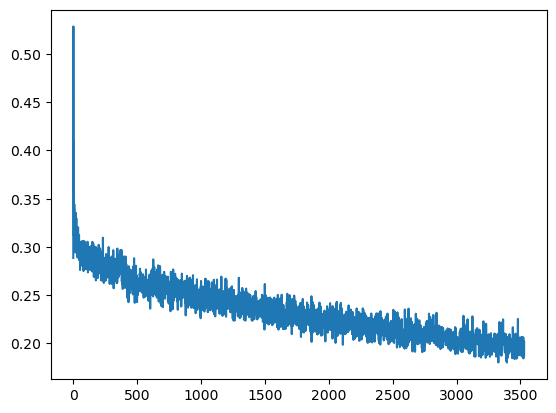

In [17]:
plt.plot(hisrelax)

In [32]:
#testpredictionwoc = get_prediction(model.eval().cpu(),TestData[102091*0:102091*1],200,8)
#trainpredictionwoc = get_prediction(model.eval().cpu(),Data,200,8)

In [19]:
relaxtestpredictionwoc = utils.get_predictionLSTM(modelrelax.eval().cpu(),TestData[102091*2:102091*3],ws,channel)
#relaxtrainpredictionwoc = utils.get_predictionLSTM(modelrelax.eval().cpu(),Data[722582*2:722582*3],ws,channel)

In [20]:
#print('Test f1 accuracy: ',f1(testlabel[204182:306273:,0].cpu(),testpredictionwoc[:,0],num_classes=2),
#      f1(testlabel[204182:306273:,1].cpu(),testpredictionwoc[:,1],num_classes=2))

print('Test f1 accuracy relaxed: ',f1(testrelaxlabel[102091*2:102091*3,0].cpu(),relaxtestpredictionwoc[:,0],num_classes=2),
      f1(testrelaxlabel[102091*2:102091*3,1].cpu(),relaxtestpredictionwoc[:,1],num_classes=2))

Test f1 accuracy relaxed:  tensor(0.8634) tensor(0.8617)


In [22]:
#print('train f1 accuracy: ',f1(label[:,0].cpu(),trainpredictionwoc[:,0],num_classes=2),
 #     f1(label[:,1].cpu(),trainpredictionwoc[:,1],num_classes=2))

print('train f1 accuracy relax: ',f1(relaxlabel[722582*0:722582*4,0].cpu(),relaxtrainpredictionwoc[:,0],num_classes=2),
      f1(relaxlabel[722582*0:722582*4,1].cpu(),relaxtrainpredictionwoc[:,1],num_classes=2))

train f1 accuracy relax:  tensor(0.9502) tensor(0.9494)


In [ ]:
for i in range(22000,22150):
    plt.plot(TestData[i:i+200,3])
    plt.plot(relaxtestpredictionwoc[i:i+ws,0].detach().numpy(),color='r')
    #plt.plot(relaxlabel[(102091*0)+i:((102091*0)+i)+200,0].detach().numpy(),color='g')
    #plt.plot(testpredictionwoc[i:i+200,0].detach().numpy(),color='b')
    #plt.plot(midpoints[i:i+200,0].detach().numpy())
    plt.plot(testlabel[(102091*0)+i:((102091*0)+i)+ws,0])
    plt.show()
    clear_output(wait=True)

In [33]:
midpoints = utils.find_midpoints(relaxtestpredictionwoc)
P_s_index,P_e_index = utils.indexes(midpoints)
T_s_index,P_e_index = utils.indexes(testlabel[102091*2:102091*3])

In [51]:
import datetime
window_sizes = [100,200]  #2
Gyro_settings = [True,False]  #2
filter_settings = [True]#,False]  #2
magnitude = [True,False]  #2
Torelax = [True,False]  #2
sensor_settings = [True,False] #2
counter = 0
for gyro in Gyro_settings:
    for filtr in filter_settings:
        for JustHand in sensor_settings:
            for ws in window_sizes:
                for relax in Torelax:
                    now = datetime.datetime.now()
                    for_now = now.strftime("%d.%m.%Y %H:%M:%S")
                    print(for_now,'\t',ws,relax,gyro,filtr,mag,hand)
                    counter+=1
counter

06.10.2023 04:48:53 	 100 True True True False False
06.10.2023 04:48:53 	 100 False True True False False
06.10.2023 04:48:53 	 200 True True True False False
06.10.2023 04:48:53 	 200 False True True False False
06.10.2023 04:48:53 	 100 True True True False False
06.10.2023 04:48:53 	 100 False True True False False
06.10.2023 04:48:53 	 200 True True True False False
06.10.2023 04:48:53 	 200 False True True False False
06.10.2023 04:48:53 	 100 True False True False False
06.10.2023 04:48:53 	 100 False False True False False
06.10.2023 04:48:53 	 200 True False True False False
06.10.2023 04:48:53 	 200 False False True False False
06.10.2023 04:48:53 	 100 True False True False False
06.10.2023 04:48:53 	 100 False False True False False
06.10.2023 04:48:53 	 200 True False True False False
06.10.2023 04:48:53 	 200 False False True False False


16

In [36]:
mae,percentage,count,hist = utils.avg_distance(T_s_index,P_s_index,16)

In [37]:
hist

tensor([278., 479., 383., 276., 172.,  88.,  59.,  41.,  29.,  23.,  15.,  14.,
          5.,  13.,  13.,  11.])

(tensor(2.7177), 0.8970240906943788, 1899, 8468)

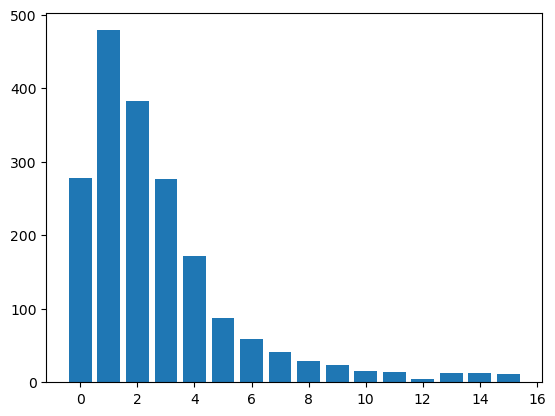

In [38]:
plt.bar(range(len(hist)),hist)
mae,percentage,count,8468

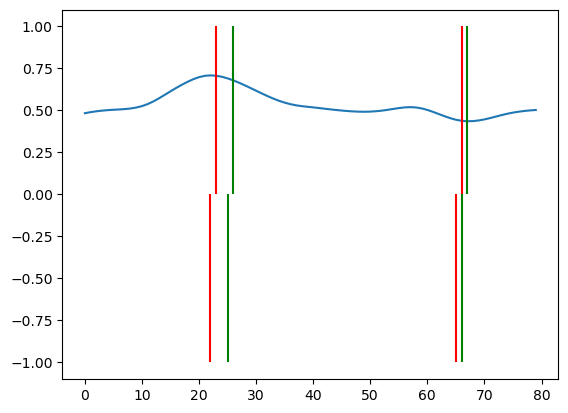

In [39]:
for i in range(1500,2000):
    plt.plot(Data[i:i+ws,2])
    plt.vlines(torch.where(midpoints[i:i+ws,0])[0],0,1,color='red')
    plt.vlines(torch.where(testlabel[i:i+ws,0])[0],0,1,color='green')
    plt.vlines(torch.where(midpoints[i:i+ws,1])[0],0,-1,color='red')
    plt.vlines(torch.where(testlabel[i:i+ws,1])[0],0,-1,color='green')
    plt.show()
    clear_output(wait=True)